### Imports

In [75]:
import json
import os
import argparse
from collections import Counter
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
import numpy as np # type: ignore

from textwrap import wrap
import matplotlib.ticker as ticker
from matplotlib import patheffects

### Read packets processed by the switch and the number of packets sent to the NIDS

In [57]:
def read_sw_info(filepath):
    packets_processed = 0
    packets_cloned = 0
    try:
        with open(filepath) as file:
            get_cloned_data, get_processed_data = False, False
            previous_line = ""
            for line in file:
                #print()
                if "Counter name:  MyEgress.cloned_to_ids" in previous_line and "Index (port):  index: 2" in line:
                    get_cloned_data = True

                if "packet_count" in line and get_cloned_data == True:
                    packets_cloned = int(line.split()[1])
                    get_cloned_data = False

                if "Counter name:  MyEgress.cloned_to_ids" in previous_line and "Index (port):  index: 3" in line:
                    get_processed_data = True

                if "packet_count" in line and get_processed_data == True:
                    packets_processed = int(line.split()[1])
                    get_processed_data = False

                previous_line = line
    except:
        print("No experiment output file in this folder")
    return packets_cloned, packets_processed

### Read amount of alerts

In [58]:
def read_amount_of_alerts(filepath):

    with open(filepath) as file:
        num_lines = len(file.readlines())
        
    return num_lines


### Read number of processed packets by Snort

In [59]:
def read_Snort_info(filepath):
    packets_received_Snort= 0 
    with open(filepath) as csvfile:
        csv_file = pd.read_csv(csvfile)
        packets_received_Snort = csv_file["daq.received"].sum()

    return packets_received_Snort
...     

Ellipsis

### Read the folder containing all experiments

In [60]:
results_folder = "../../../results"

data = []
for pps_folder in os.listdir(results_folder):
    if pps_folder == "Experiment":
        continue
    
    for scenario in os.listdir(os.path.join(results_folder, pps_folder)):
        for experiment_round in os.listdir(os.path.join(results_folder, pps_folder, scenario)):
            abs_path = os.path.join(results_folder, pps_folder, scenario, experiment_round)
            packets_cloned, packets_processed = read_sw_info(os.path.join(abs_path, "stdout_output.txt"))
            alerts = read_amount_of_alerts(os.path.join(abs_path, "eth0/alert_json.txt"))
            packets_received_Snort = read_Snort_info(os.path.join(abs_path, "eth0/perf_monitor_base.csv"))
            
            data.append([pps_folder, scenario, experiment_round, packets_cloned, packets_processed, packets_received_Snort, alerts])
    
df = pd.DataFrame(data, columns=["pps","scenario","round","packets cloned","packets processed","packets received by snort","alerts"])


### Graph functions of the Frydat PCAP for pps and scenario analysys 

In [82]:
font = {'size'   : 10}
plt.rc('font', **font)

# Add a label on top of each bar plot
def add_value_labels(ax, decimal_format=0, spacing=8, y_spacing=0, color='black'):
    for rect in ax.patches[0:5]:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
     
        # Use Y value as label and format number with one decimal place
        str_ = "{:."+str(decimal_format)+"f}"
        label = str_.format(y_value)
        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(y_spacing, spacing),          # Vertically shift label by `spacing`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va='bottom',                      # Vertically align label for positive values ('bottom' for positive, 'top' for negatives).
            color=rect.get_facecolor(),
            weight='bold',
            path_effects=[patheffects.withStroke(linewidth=3, foreground="black")]
            )    

def plot_bar_graphs(df, metric, ylabel, yticks_distance, ymargin=0):
    friday_pcap = df[(df["round"].str.contains("Friday"))]
    groupped_df = friday_pcap[["pps", "scenario", "round", metric]].groupby(["pps", "scenario"], as_index=False).agg({metric:['mean','std']})
    groupped_df.columns = groupped_df.columns.map(lambda x: x[0] if x[1] == "" else x[1])
    
    new_df = groupped_df.pivot(index = "scenario", columns="pps", values="mean").fillna(0)
    new_df.rename(columns={'PCAP_timeline':'PCAP'}, inplace=True)
    new_df = new_df.iloc[np.r_[0:len(new_df) - 2, -1, -2]]
    new_df = new_df[["PCAP", "7.5kpps", "15kpps", "30kpps"]]
    error = groupped_df.pivot(index = "scenario", columns="pps", values="std").fillna(0)
    error.rename(columns={'PCAP_timeline':'PCAP'}, inplace=True)
    error = error.iloc[np.r_[0:len(new_df) - 2, -1, -2]]
    error = error[["PCAP", "7.5kpps", "15kpps", "30kpps"]]

    # labels = ['\n'.join(wrap(l.replace("_", " "),12)) for l in labels ]
    labels = ["B. no\nSampling", "B. with\nSampling\n(N=2)", "Only\ncountmin", "Only rules", "Rules and\ncountmin"]

    ax = new_df.plot(kind='bar', yerr=error, error_kw=dict(capsize=2), rot=0)
    add_value_labels(ax)   
    ax.margins(y=ymargin)
    plt.xticks([0,1,2,3,4], labels)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(yticks_distance))
    plt.ylabel(ylabel, labelpad=15)
    plt.xlabel(xlabel=None)
    plt.legend(bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.savefig("pps_graphs/"+metric+".png")

### Plot alerts graphs

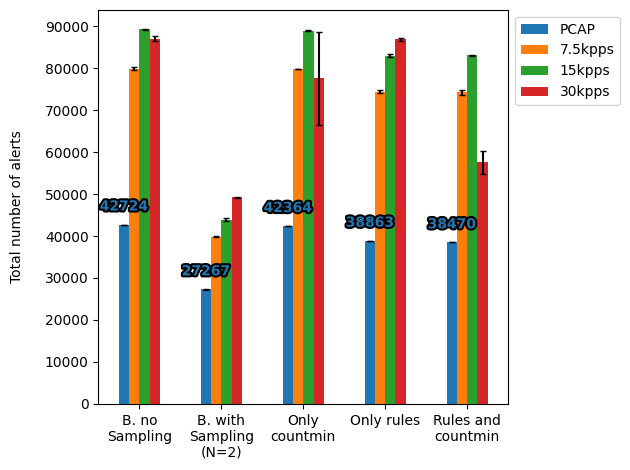

In [83]:
plot_bar_graphs(df, "alerts", "Total number of alerts", 10000, 0.05)

### Plot packets processed by the switch

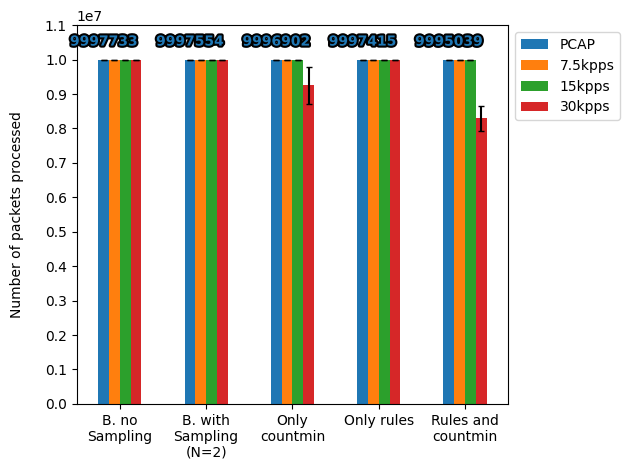

In [84]:
plot_bar_graphs(df, "packets processed", "Number of packets processed", 1000000, 0.1)

### Plot packets sent to the NIDS host and packet processed by the NIDS

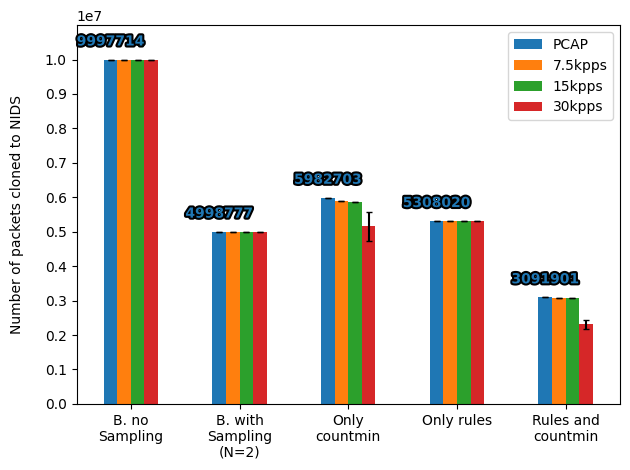

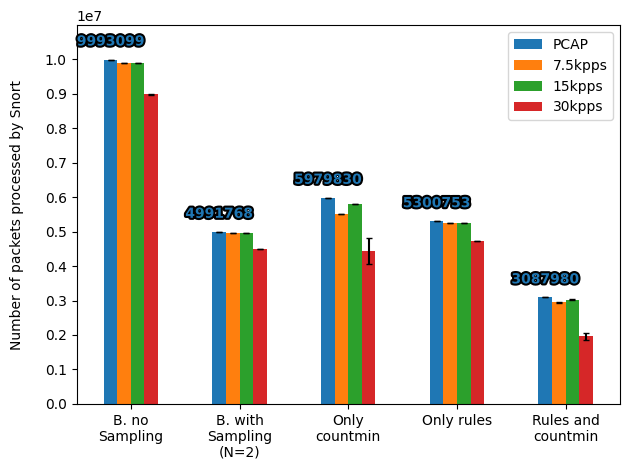

In [85]:
plot_bar_graphs(df, "packets cloned", "Number of packets cloned to NIDS", 1000000, 0.1)

plot_bar_graphs(df, "packets received by snort", "Number of packets processed by Snort", 1000000, 0.1)